In [1]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
def model(t_u, w, b, w2):
    return w2 * t_u ** 2 + w * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
w = torch.ones(())
b = torch.zeros(())
w2 = torch.zeros(())

t_p = model(t_u, w, b, w2)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [6]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [7]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b, w2), t_c) - 
     loss_fn(model(t_u, w - delta, b, w2), t_c)) / (2.0 * delta)

In [8]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [9]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta, w2), t_c) - 
     loss_fn(model(t_u, w, b - delta, w2), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [10]:
loss_rate_of_change_w2 = \
    (loss_fn(model(t_u, w, b, w2 + delta), t_c) - 
     loss_fn(model(t_u, w, b, w2 - delta), t_c)) / (2.0 * delta)

w2 = w2 - learning_rate * loss_rate_of_change_w2

In [11]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [12]:
def dmodel_dw2(t_u, w, b,w2):
    return 2*t_u

In [13]:
def dmodel_db(t_u, w, b, w2):
    return 1.0

In [14]:
def dmodel_dw(t_u, w, b,w2):
    return t_u

In [15]:
def grad_fn(t_u, t_c, t_p, w, b, w2):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b, w2)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b, w2)
    dloss_dw2 = dloss_dtp * dmodel_dw2(t_u, w, b, w2)
    return torch.stack([dloss_dw.sum(), dloss_db.sum(), dloss_dw2.sum()])

In [16]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b, w2 = params

        t_p = model(t_u, w, b, w2)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b, w2)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [44]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b, w2 = params

        t_p = model(t_u, w, b, w2)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b, w2)  # <2>

        params = params - learning_rate * grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

        
            
    return params

In [45]:
t_un = 0.1 * t_u

In [46]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-3, 
    params = torch.tensor([1.0, 0.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 500, Loss 12.609796
Epoch 1000, Loss 9.988191
Epoch 1500, Loss 8.023678
Epoch 2000, Loss 6.552407
Epoch 2500, Loss 5.451283
Epoch 3000, Loss 4.627817
Epoch 3500, Loss 4.012551
Epoch 4000, Loss 3.553331
Epoch 4500, Loss 3.211003
Epoch 5000, Loss 2.956184


tensor([ 1.1788, -5.8596,  0.3577])

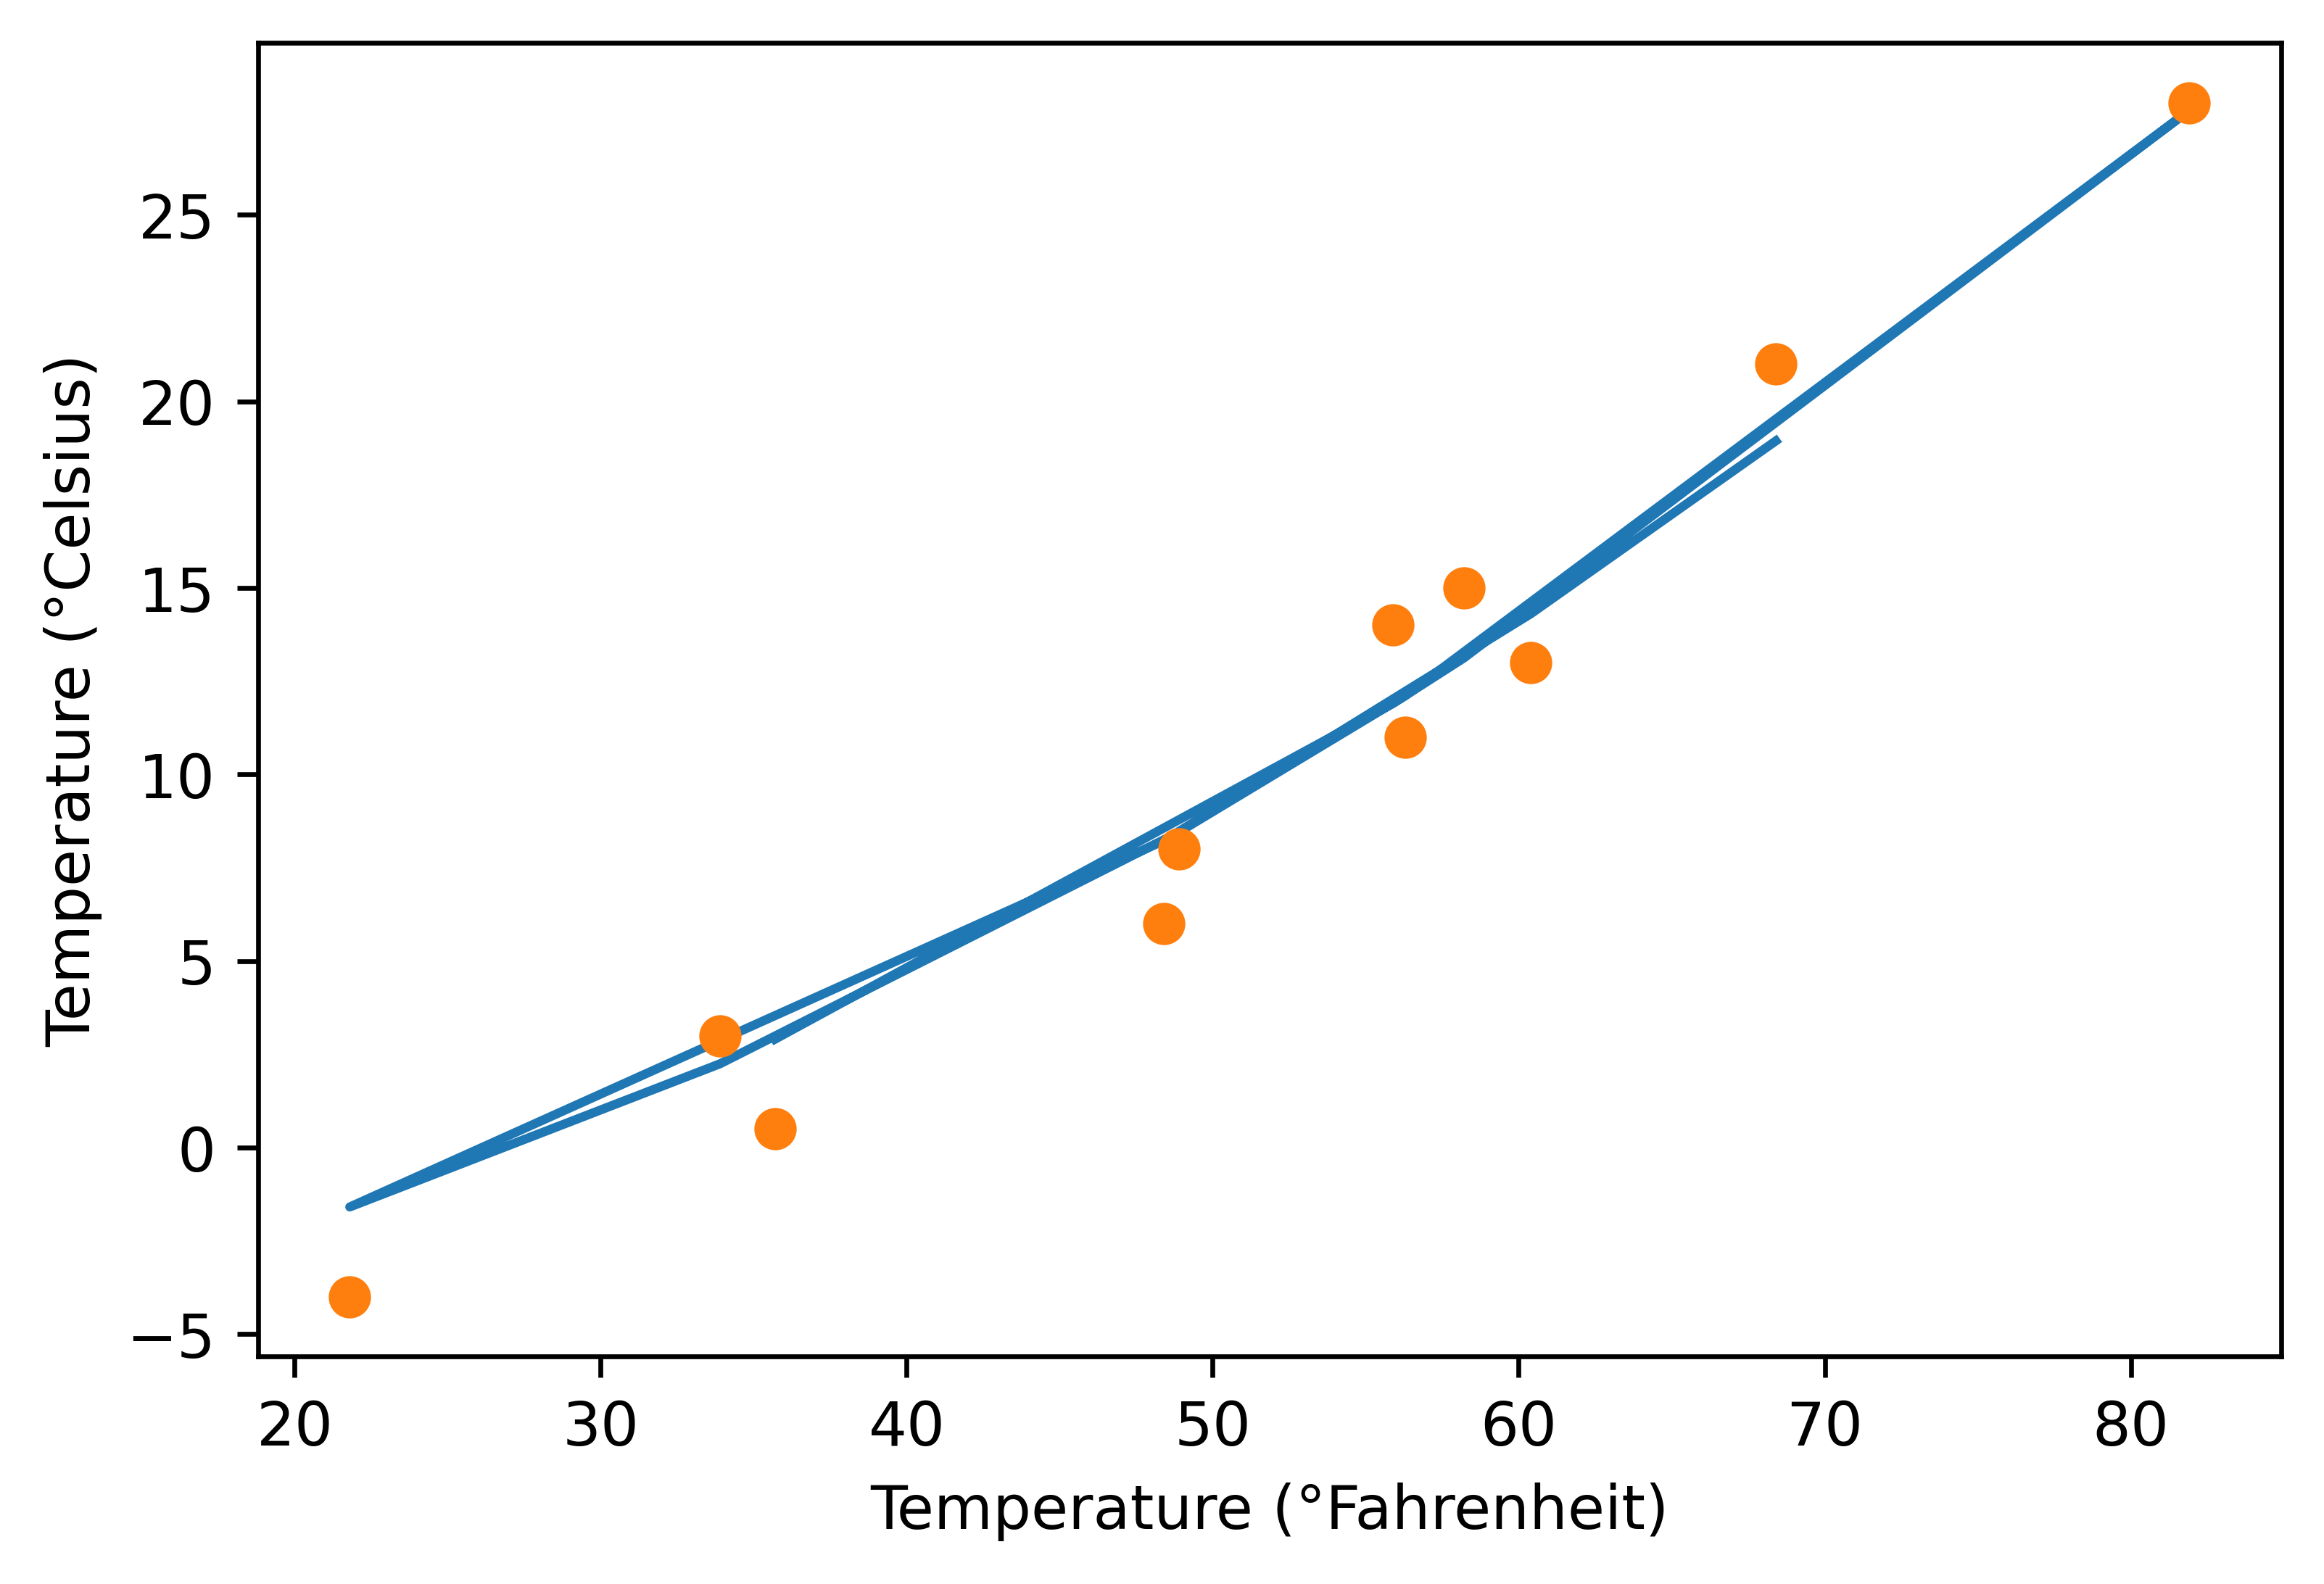

In [42]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip